In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

plt.style.use('dark_background')
plt.rc('axes', titlesize=24, labelsize=20, labelpad=5)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)              
plt.rc('legend', fontsize=12)

np.random.seed(47)
num_points = 50

In [2]:
# Generate synthetic data
x1 = np.random.randint(1, 100, num_points)
x2 = np.random.randint(10, 200, num_points)
noise = np.random.normal(0, 1, num_points)

# True relationship (without noise)
true_params = [10, 0.4, 0.6]
y_true = true_params[0] + true_params[1] * x1 + true_params[2] * x2

# Add noise to the true relationship
y = y_true + noise

# Add outliers to the data
y[-2:] += 200

#### Huber Loss

The **Huber loss** is a combination of MSE and MAE, robust to outliers.

### Formula

For a single data point, the Huber loss is defined as:

$$
L_\delta(y, \hat{y}) =
\begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{if} \ |y - \hat{y}| \leq \delta \\
\delta |y - \hat{y}| - \frac{1}{2} \delta^2 & \text{if} \ |y - \hat{y}| > \delta
\end{cases}
$$

Where:
- $y$ is the true value
- $\hat{y}$ is the predicted value
- $\delta$ is the threshold parameter

Interpretation:
- **Smooth for small errors**: Quadratic ($\frac{1}{2}(y - \hat{y})^2$)
- **Linear for large errors**: Absolute ($\delta |y - \hat{y}|$)

In [3]:
def huber_loss(betas, X, y, delta):
    predictions = X @ betas
    residuals = np.abs(y - predictions)

    quadratic_part = (residuals <= delta) * (0.5 * residuals ** 2) 
    linear_part = (
        (residuals > delta) * (delta * residuals - 0.5 * delta ** 2)
    )
    return np.sum(quadratic_part + linear_part)

In [4]:
def mse_loss(params, X, y):
    predictions = X @ params
    return np.mean((y - predictions)**2)

In [5]:
def optimize_loss(loss_function, X, y, delta=None):
    n_features = X.shape[1]

    initial_params = np.zeros(n_features)

    if delta is not None:
        result = minimize(loss_function, initial_params,
                          args=(X, y, delta), method='L-BFGS-B')
    else:
        result = minimize(loss_function, initial_params,
                          args=(X, y), method='L-BFGS-B')

    return result.x

In [6]:
X = np.column_stack((x1, x2))
X = np.c_[np.ones(num_points), X]  # Add Ones to learn intercept
X[: 2]

array([[  1.,   8.,  96.],
       [  1.,   7., 169.]])

In [7]:
params_huber = optimize_loss(huber_loss, X, y, delta=1.0)
params_mse = optimize_loss(mse_loss, X, y)

In [8]:
# Print parameters
print(f'True parameters: {true_params}')
print(f'Optimized parameters (Huber loss): {params_huber}')
print(f'Optimized parameters (MSE loss): {params_mse}')

True parameters: [10, 0.4, 0.6]
Optimized parameters (Huber loss): [9.75731122 0.40018164 0.60194369]
Optimized parameters (MSE loss): [29.92042345  0.62633922  0.39869457]


In [9]:
y_pred_mse = X @ params_mse
y_pred_huber = X @ params_huber

r2_mse = r2_score(y, y_pred_mse)
r2_huber = r2_score(y, y_pred_huber)

# Print R² for both models
print(f'R² with MSE loss: {r2_mse}')
print(f'R² with Huber loss: {r2_huber}')

R² with MSE loss: 0.3629197532543441
R² with Huber loss: 0.2719537260992476


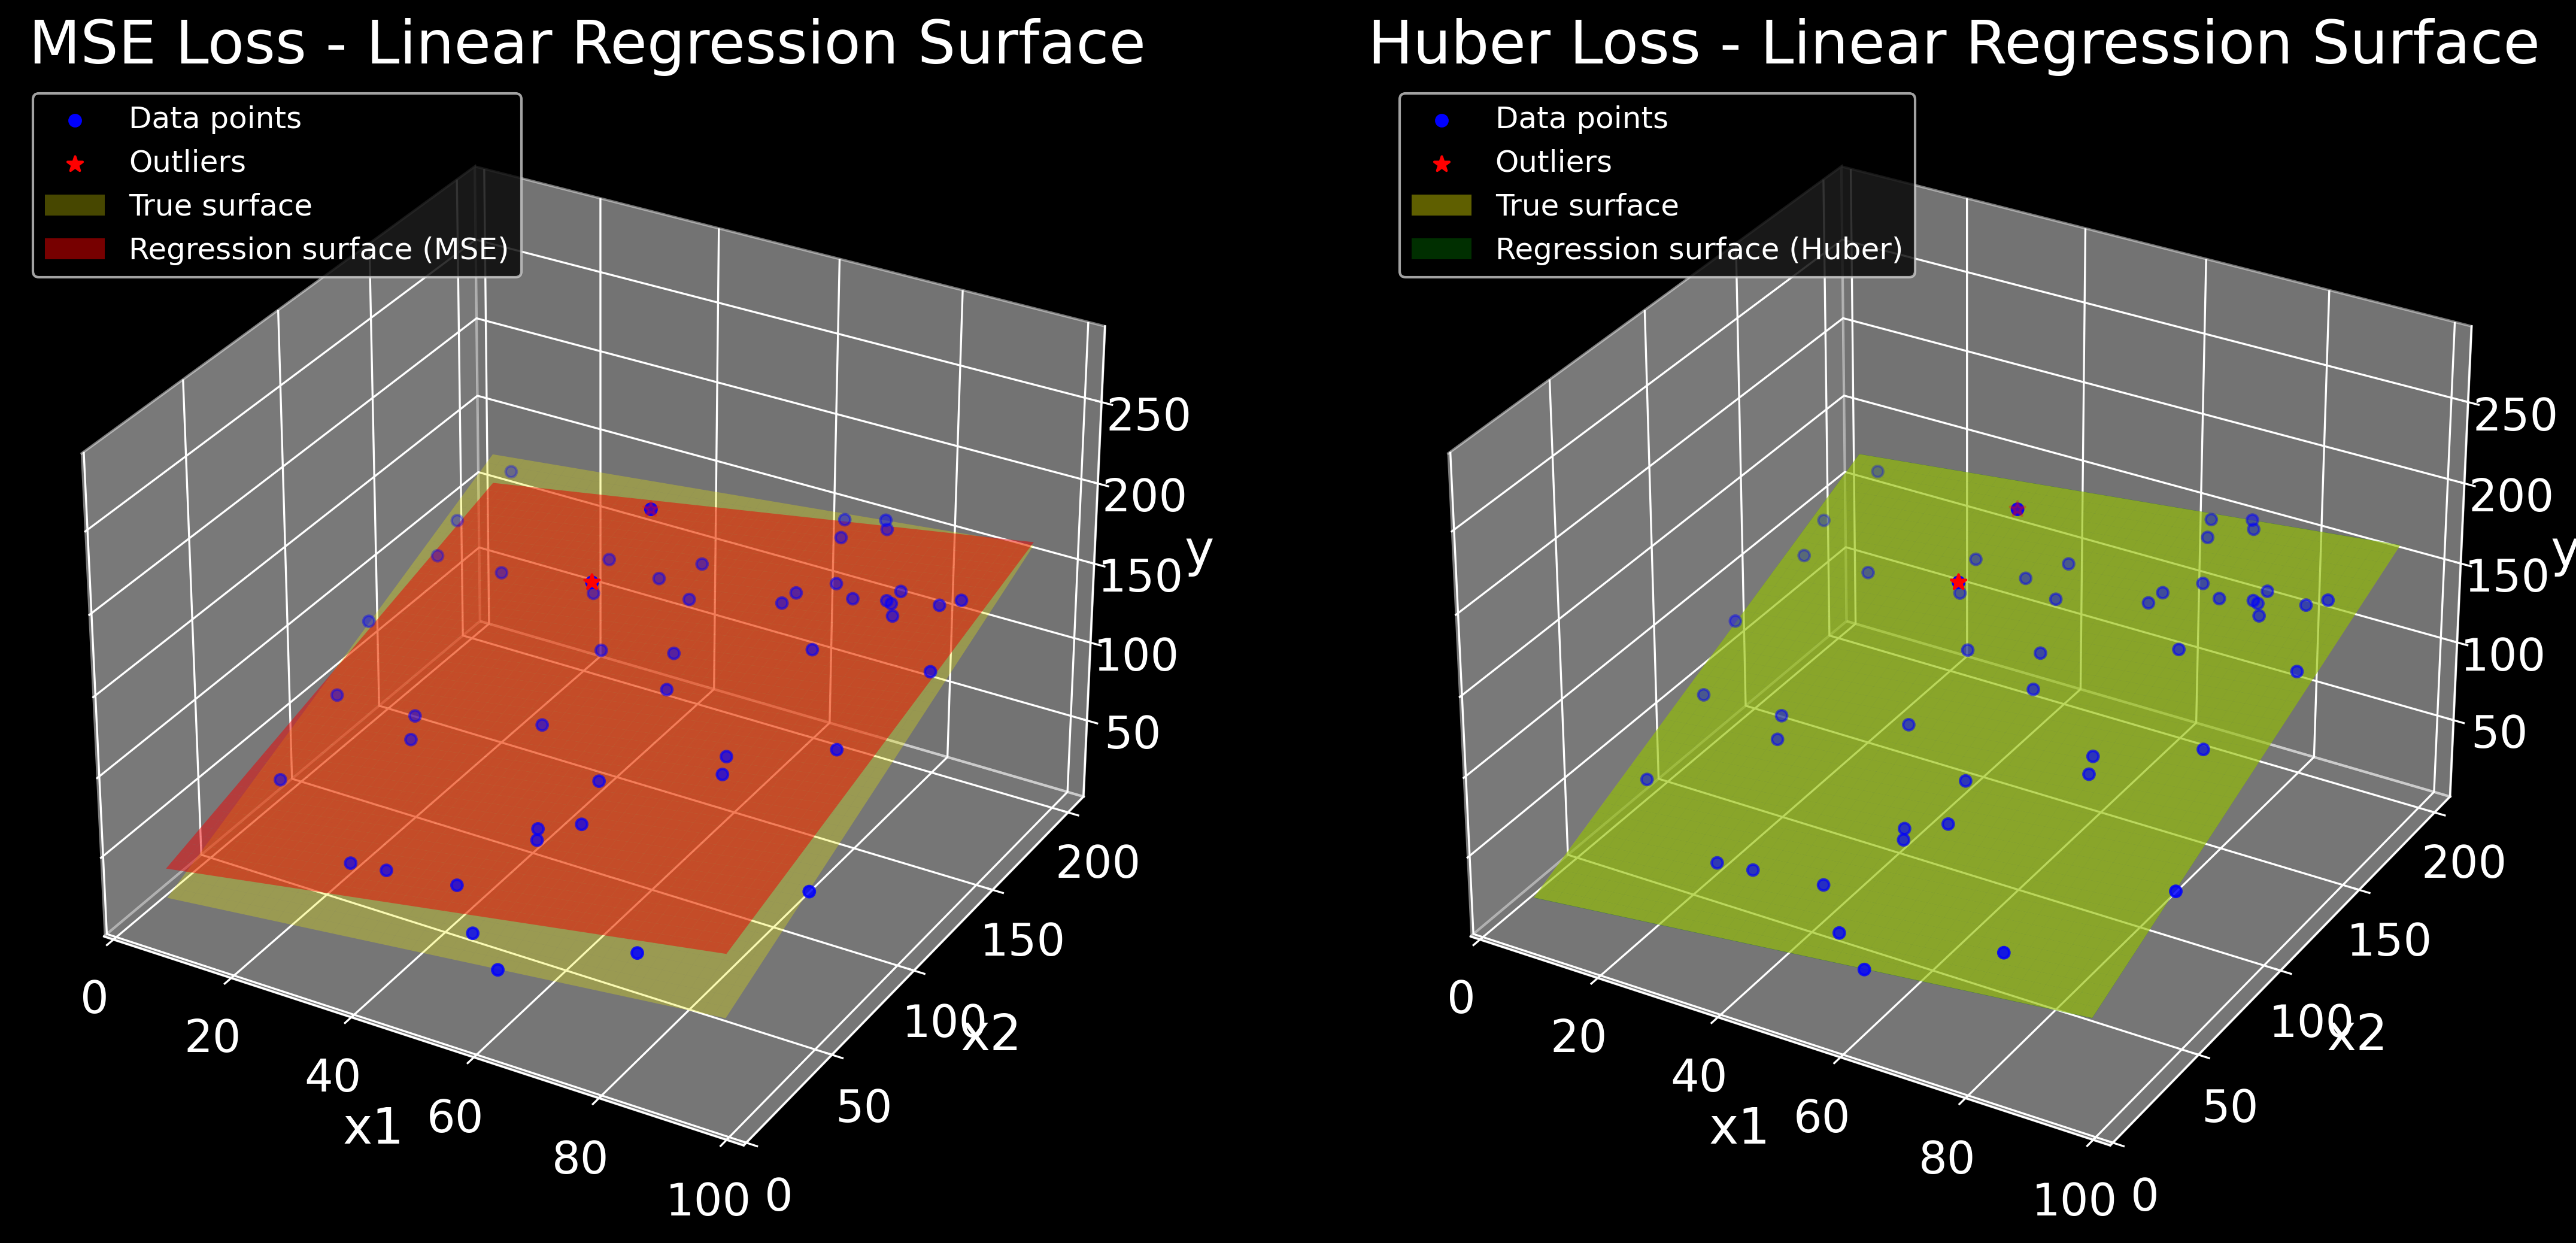

In [10]:
# 3D Plotting: Linear Regression Surface
fig = plt.figure(figsize=(18, 15), dpi=300)

plt.subplots_adjust(wspace=0.2)
# Plot for MSE model
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, x2, y, color='blue', label='Data points', s=20)
ax1.scatter(x1[-2:], x2[-2:], y[-2:], color='red', label='Outliers', marker='*', s=40)  # Highlight outliers

# Create a grid of points to plot the regression surface
x1_grid, x2_grid = np.meshgrid(np.linspace(min(x1), max(x1), 50), np.linspace(min(x2), max(x2), 50))
X_grid = np.c_[np.ones(x1_grid.size), x1_grid.ravel(), x2_grid.ravel()]
y_grid_mse = X_grid @ params_mse
y_grid_mse = y_grid_mse.reshape(x1_grid.shape)

# True relationship surface
y_true_surface = true_params[0] + true_params[1] * x1_grid + true_params[2] * x2_grid
ax1.plot_surface(x1_grid, x2_grid, y_true_surface, color='yellow', alpha=0.3, label='True surface')
ax1.plot_surface(x1_grid, x2_grid, y_grid_mse, color='red', alpha=0.5, label='Regression surface (MSE)')
ax1.set_title('MSE Loss - Linear Regression Surface')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x1, x2, y, color='blue', label='Data points', s=20)
ax2.scatter(x1[-2:], x2[-2:], y[-2:], color='red', label='Outliers', marker='*', s=40)  # Highlight outliers
ax2.plot_surface(x1_grid, x2_grid, y_true_surface, color='yellow', alpha=0.4, label='True surface')
y_grid_huber = X_grid @ params_huber
y_grid_huber = y_grid_huber.reshape(x1_grid.shape)
ax2.plot_surface(x1_grid, x2_grid, y_grid_huber, color='green', alpha=0.4, label='Regression surface (Huber)')
ax2.set_title('Huber Loss - Linear Regression Surface')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.show()

In [11]:
true_params

[10, 0.4, 0.6]

In [12]:
params_huber

array([9.75731122, 0.40018164, 0.60194369])

In [13]:
params_mse

array([29.92042345,  0.62633922,  0.39869457])